In [1]:
# Explore Training the Auto MPG regression dataset

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import SGDRegressor

%matplotlib inline

In [3]:
# Load data
colnames = ['mpg', 'cylinders', 'displacement', 'horsepower', 'weight',
 'acceleration', 'model year', 'origin', 'car name']

df = pd.read_csv('./auto-mpg/auto-mpg/auto-mpg.data.txt',
                header=None, names=colnames,
                sep='\s+',
                na_values=['?'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 398 entries, 0 to 397
Data columns (total 9 columns):
mpg             398 non-null float64
cylinders       398 non-null int64
displacement    398 non-null float64
horsepower      392 non-null float64
weight          398 non-null float64
acceleration    398 non-null float64
model year      398 non-null int64
origin          398 non-null int64
car name        398 non-null object
dtypes: float64(5), int64(3), object(1)
memory usage: 28.1+ KB


## Data Engineering

In [4]:
# Clean data

df.drop('car name', inplace=True, axis=1)
df.dropna(inplace=True)

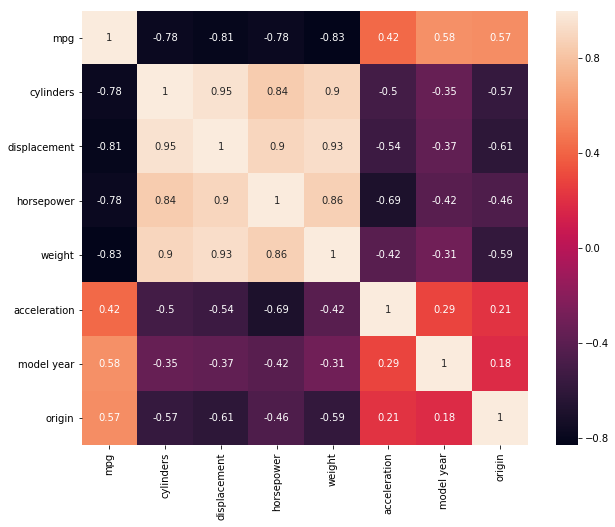

In [5]:
# Explore correlation and pairplot

df.corr()

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), annot=True, ax=ax)

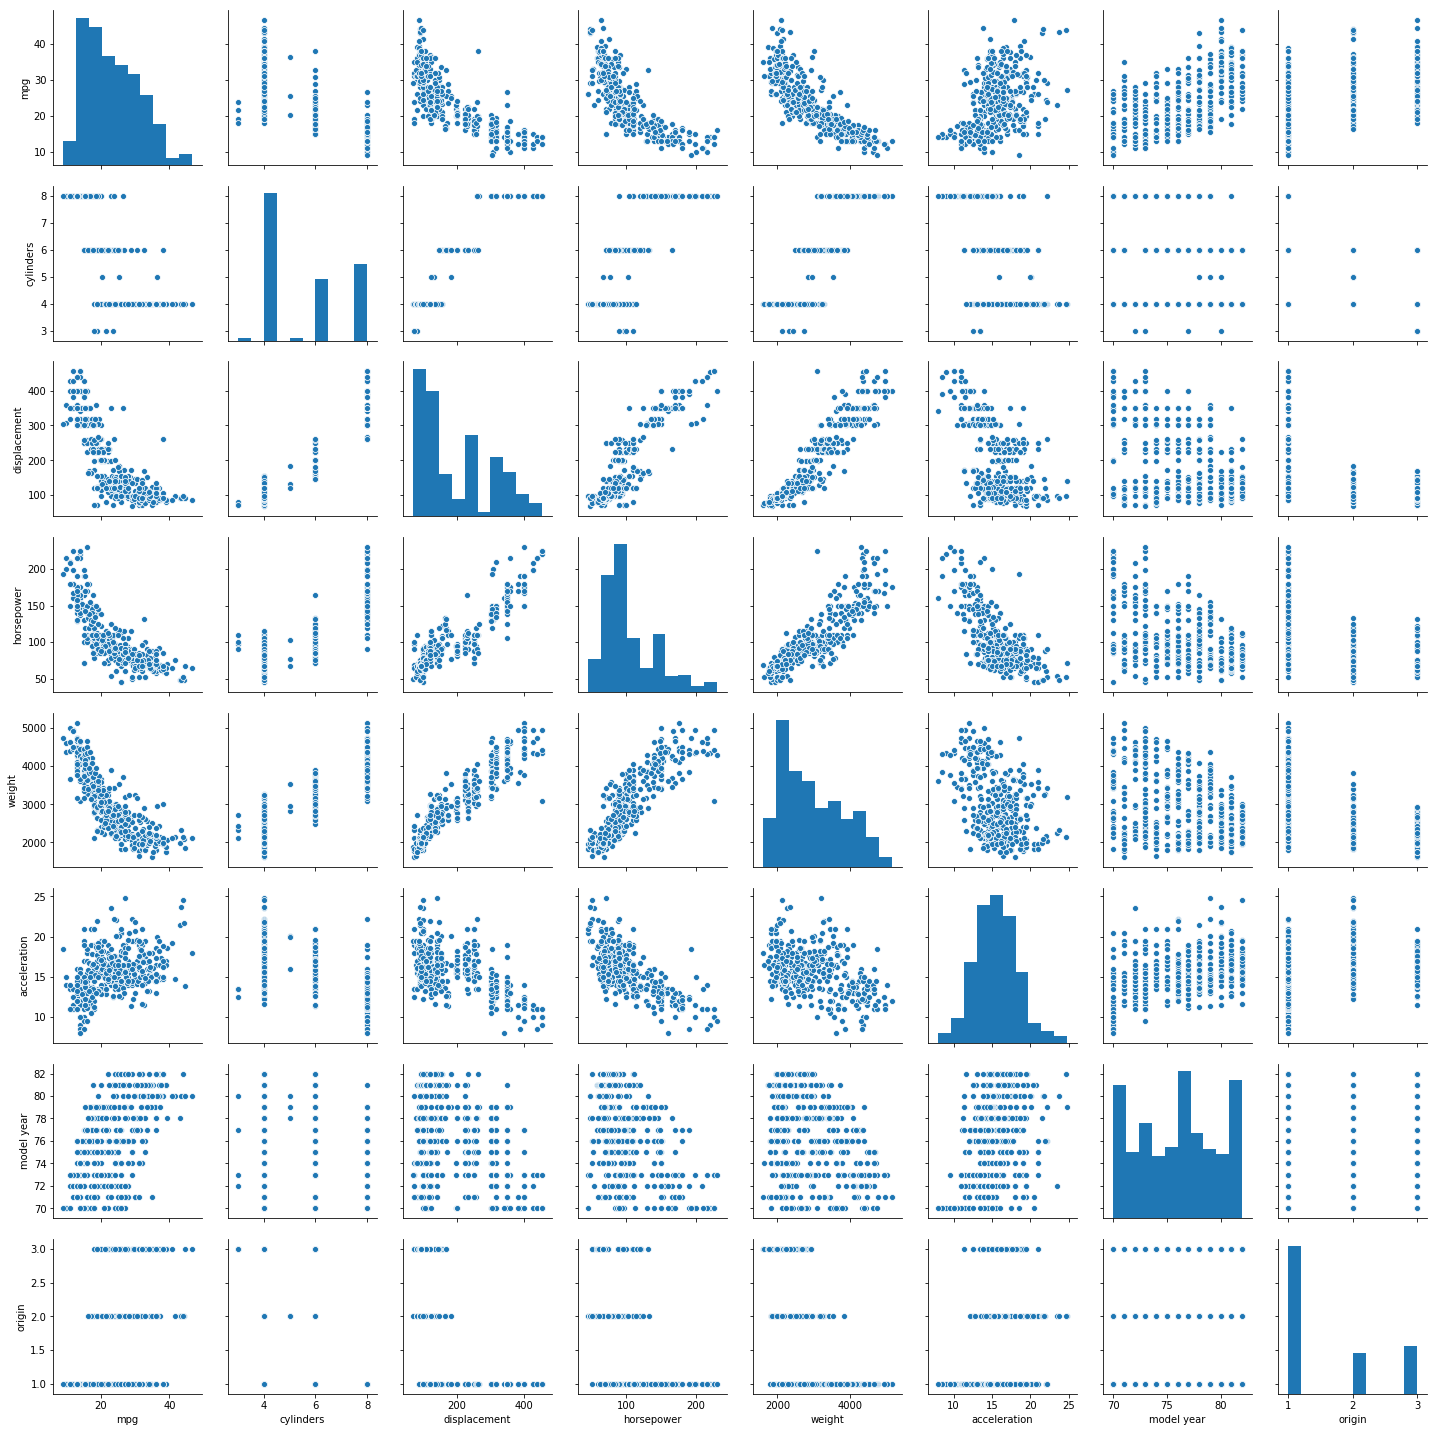

In [6]:
sns.pairplot(df)

In [7]:
target = 'mpg'
features = df.columns != target

X = df.loc[:, features]
y = df[target]

In [8]:
# PCA
# Goal: plot all 8 features at the same time with target (y)
# PCA is a technique to reduce to 2 or 3 dimensions

# Principal Component Analysis

# best practice is to scale before performing PCA
# (because PCA uses covariance which is sensitive to scaling)
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

pca = PCA(n_components=1) # X in 1-d so we can plot X vs y in 2-d
pca.fit(X_scaled) # setup to compute PCA

Z = pca.transform(X_scaled) # actually perform PCA

# dimension is 1 only because we want to plot
print('before', X.shape, 'after', Z.shape)

before (392, 7) after (392, 1)


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:11: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # This is added back by InteractiveShellApp.init_path()


[Text(0, 0.5, 'mpg'),
 Text(0.5, 0, '1-d PCA projection of data'),
 Text(0.5, 1.0, 'PCA of data vs. mpg')]

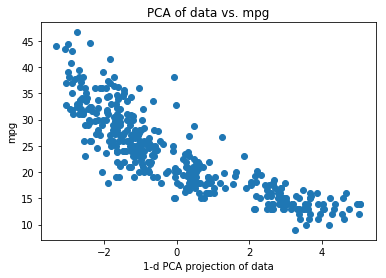

In [9]:
# plot Z vs. y to explore relationship
fig, ax = plt.subplots()
ax.scatter(Z, y)
ax.set(title='PCA of data vs. mpg',
      xlabel='1-d PCA projection of data',
      ylabel='mpg')

## Feature Selection / Reduction

In [10]:
# just an experiment in case we want to reduce features
# we can use that later to see if model performs better

kbest = SelectKBest(score_func=f_regression, k=5)
X_kbest = kbest.fit_transform(X, y)

print('best features', X.columns[kbest.get_support()])
print('before', X.shape, 'after', X_kbest.shape)

print('Features that y depends on most:')
for feature, score in zip(X.columns, kbest.scores_):
    print(feature, score)

best features Index(['cylinders', 'displacement', 'horsepower', 'weight', 'model year'], dtype='object')
before (392, 7) after (392, 5)
Features that y depends on most:
cylinders 596.5649807181177
displacement 718.6770763503403
horsepower 599.7177409015798
weight 878.830886413205
acceleration 85.15028007275659
model year 198.25997203130837
origin 183.07511377409918


## Training

- Train test split
- Iteratively:
 - Select model parameters
 - Cross validate
 - Plot learning curve

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(294, 7) (98, 7) (294,) (98,)


In [12]:
# scale X_train to normalise the feature ranges
X_scaler = StandardScaler()
Z_train = X_scaler.fit_transform(X_train)

C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [13]:
# Cross validation

# define our model
#   Linear Regression using Gradient Descent

model = SGDRegressor(max_iter=1000, tol=1e-3,
                     random_state=8)

# scores should look like this (k entries, one for each group):
# [ {train_score: xxx, test_score: yyy, ...}, # [T,T,T,T,V]
#   {train_score: xxx, test_score: yyy, ...}, # [T,T,T,V,T]
# ]
scores = cross_validate(model, Z_train, y_train, cv=5,
                        return_train_score=True,
                        return_estimator=True) # models
scores

{'fit_time': array([0.00400615, 0.00300908, 0.00701737, 0.00501227, 0.00804663]),
 'score_time': array([0.00100327, 0.00100374, 0.00100493, 0.00100708, 0.00097561]),
 'estimator': (SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
         eta0=0.01, fit_intercept=True, l1_ratio=0.15,
         learning_rate='invscaling', loss='squared_loss', max_iter=1000,
         n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
         random_state=8, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False),
  SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
         eta0=0.01, fit_intercept=True, l1_ratio=0.15,
         learning_rate='invscaling', loss='squared_loss', max_iter=1000,
         n_iter=None, n_iter_no_change=5, penalty='l2', power_t=0.25,
         random_state=8, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False),
  SGDRegressor(alpha=0.0001, average=Fa

In [14]:
# Regressor scores usually R2
#SGDRegressor.score?

# in contrast Classifier scores usually use mean accuracy
#from sklearn.linear_model import SGDClassifier
#SGDClassifier.score?

In [15]:
# Get the W and bias for each fitted linear regressor
for m in scores['estimator']:
    print('W', m.coef_, 'bias', m.intercept_)

W [-0.66127558  0.0657522  -0.76787578 -3.90088195 -0.50829644  2.72643614
  1.11358716] bias [23.35774683]
W [-0.71612     0.69811686 -1.32398256 -3.712918   -0.58004681  2.93476063
  1.24198068] bias [23.29195301]
W [-0.84765615  1.8020263  -0.83781095 -4.76633577 -0.06744204  2.887253
  1.35112053] bias [23.17598391]
W [-0.88966186  0.82777088 -0.31390168 -4.25071635 -0.08131739  2.88053443
  1.56867998] bias [23.36255299]
W [-0.79890139  1.01794427 -1.13644559 -4.27762848 -0.50280441  2.95283971
  1.14957441] bias [23.27366348]


In [16]:
# Score for test set (the 25% from train_test_split)
# Note that 'test_score' returned by cross_validate is actually
# 'validation score'. (easy to confuse)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

models = scores['estimator']

# let's see the first model
Z_test = X_scaler.transform(X_test) # common mistake is to use
                                    # X_scaler.fit_transform
                                    # which will reset the scaler
y_pred = models[0].predict(Z_test)

print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred)) # scale-invariant

MSE: 12.155330171660585
MAE: 2.6293975148618194
R2: 0.797774905070395


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


## Learning Curve

[Text(0, 0.5, 'R2'),
 Text(0.5, 0, 'Train size'),
 Text(0.5, 1.0, 'Learning curve')]

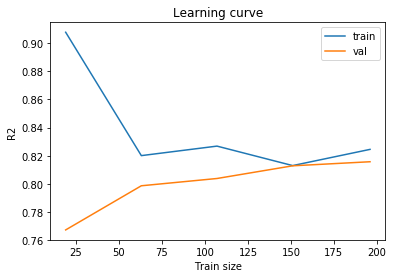

In [17]:
from sklearn.model_selection import learning_curve

# 5-fold cross validation to get learning curve R2 scores
# using default train_sizes
train_sizes, train_scores, val_scores = learning_curve(model,
                                                       Z_train, 
                                                       y_train, cv=3)

# plot learning curve:
#   plot train_scores vs. train_sizes
#   plot val_scores vs. train_sizes
# train_sizes is the number of training samples used for training

fig, ax = plt.subplots()
ax.plot(train_sizes, train_scores.mean(axis=1),
        label='train') # average for 5-folds
ax.plot(train_sizes, val_scores.mean(axis=1),
        label='val')
ax.legend()
ax.set(title='Learning curve', xlabel='Train size', ylabel='R2')


## Tuning

Guideline: try to change only one thing at a time
- Learning Rate
- Regularization
- Grid search
- Kbest features

In [18]:
# process
# - make change
# - cross validate (trains models)
# - learning curve (plot for overfit / underfit)

In [19]:
# helper function to reduce coding
def plot_learning_curve(model):
    # 3-fold cross validation to get learning curve R2 scores
    # using default train_sizes
    train_sizes, train_scores, val_scores = learning_curve(model,
                                                           Z_train, 
                                                           y_train, cv=3)

    # plot learning curve:
    #   plot train_scores vs. train_sizes
    #   plot val_scores vs. train_sizes
    # train_sizes is the number of training samples used for training

    fig, ax = plt.subplots()
    ax.plot(train_sizes, train_scores.mean(axis=1),
            label='train') # average for 5-folds
    ax.plot(train_sizes, val_scores.mean(axis=1),
            label='val')
    ax.legend()
    ax.set(title='Learning curve', xlabel='Train size', ylabel='R2')
    return train_sizes, train_scores, val_scores

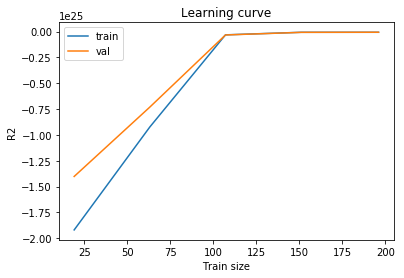

In [20]:
# SGDRegressor.learning_rate
# default was 'invscaling'
# try: 'constant' with eta0=1e-1, 'constant' with eta0=1e-4,
# 'optimal' with default eta0

# - make change
model = SGDRegressor(max_iter=1000, tol=1e-3,
                     random_state=8,
                     learning_rate='optimal')

# - cross validate (trains models)
scores = cross_validate(model, Z_train, y_train, cv=5,
                        return_train_score=True, return_estimator=True)
# scores

# - learning curve (plot for overfit / underfit)
train_sizes, train_scores, val_scores = plot_learning_curve(model)

In [21]:
# Searching is time consuming
# Use GridSearchCV to automate finding the best combination

from sklearn.model_selection import GridSearchCV

# Parameters to try:
# learning_rate='invscaling'
#  'constant' with eta0=1e-1
#  'constant' with eta0=1e-4,
#  'optimal' with default eta0
params = {
    'learning_rate' : ['invscaling', 'constant', 'optimal'],
    'eta0' : [0.01, 1e-1, 1e-3, 1e-4]
}

# consider setting n_jobs to run more in parallel if too slow
gs = GridSearchCV(model, params, cv=3, return_train_score=True)
gs.fit(Z_train, y_train)

print(gs.best_score_) # best score of 12 models
print(gs.best_params_) # best parameters
# print(gs.best_estimator_) # best of 12 models (12 combinations of params)

results_df = pd.DataFrame(gs.cv_results_)
results_df

0.8157809300685853
{'eta0': 0.01, 'learning_rate': 'invscaling'}


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_eta0,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,0.004178,0.000948,0.000501,4.899036e-07,0.01,invscaling,"{'eta0': 0.01, 'learning_rate': 'invscaling'}",7.621917e-01,8.530196e-01,8.321315e-01,8.157809e-01,3.884099e-02,1,8.494434e-01,8.086249e-01,8.156274e-01,8.245652e-01,1.782228e-02
1,0.001170,0.000236,0.000836,2.165905e-04,0.01,constant,"{'eta0': 0.01, 'learning_rate': 'constant'}",7.684656e-01,8.449227e-01,8.323845e-01,8.152576e-01,3.348052e-02,2,8.496960e-01,8.088373e-01,8.168906e-01,8.251413e-01,1.767132e-02
2,0.002005,0.000820,0.000334,4.721571e-04,0.01,optimal,"{'eta0': 0.01, 'learning_rate': 'optimal'}",-1.269129e+23,-2.617242e+22,-2.116120e+22,-5.808217e+22,4.871365e+22,9,-1.463071e+23,-2.351665e+22,-1.578170e+22,-6.186848e+22,5.979056e+22
3,0.001337,0.000472,0.000668,4.722695e-04,0.1,invscaling,"{'eta0': 0.1, 'learning_rate': 'invscaling'}",7.562792e-01,8.435292e-01,8.315472e-01,8.104519e-01,3.861692e-02,4,8.386249e-01,8.087981e-01,8.091365e-01,8.188532e-01,1.398139e-02
4,0.000335,0.000473,0.000668,4.725505e-04,0.1,constant,"{'eta0': 0.1, 'learning_rate': 'constant'}",6.806542e-01,7.296155e-01,6.756348e-01,6.953015e-01,2.435002e-02,7,7.501105e-01,7.123314e-01,6.785356e-01,7.136592e-01,2.923541e-02
5,0.002338,0.000475,0.000334,4.728314e-04,0.1,optimal,"{'eta0': 0.1, 'learning_rate': 'optimal'}",-1.269129e+23,-2.617242e+22,-2.116120e+22,-5.808217e+22,4.871365e+22,9,-1.463071e+23,-2.351665e+22,-1.578170e+22,-6.186848e+22,5.979056e+22
6,0.010358,0.001704,0.000000,0.000000e+00,0.001,invscaling,"{'eta0': 0.001, 'learning_rate': 'invscaling'}",7.477095e-01,8.494347e-01,8.242690e-01,8.071377e-01,4.325978e-02,6,8.437586e-01,7.944521e-01,8.044245e-01,8.142117e-01,2.128578e-02
7,0.001337,0.000472,0.000668,4.726067e-04,0.001,constant,"{'eta0': 0.001, 'learning_rate': 'constant'}",7.604762e-01,8.534968e-01,8.316461e-01,8.152064e-01,3.971485e-02,3,8.489328e-01,8.078791e-01,8.147158e-01,8.238426e-01,1.795965e-02
8,0.001858,0.000263,0.000169,2.383826e-04,0.001,optimal,"{'eta0': 0.001, 'learning_rate': 'optimal'}",-1.269129e+23,-2.617242e+22,-2.116120e+22,-5.808217e+22,4.871365e+22,9,-1.463071e+23,-2.351665e+22,-1.578170e+22,-6.186848e+22,5.979056e+22
9,0.018467,0.009495,0.000000,0.000000e+00,0.0001,invscaling,"{'eta0': 0.0001, 'learning_rate': 'invscaling'}",-7.008334e-03,-3.437823e-02,2.353682e-02,-5.949916e-03,2.365556e-02,8,8.349491e-03,8.283756e-02,4.407060e-02,4.508588e-02,3.041810e-02


C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  ConvergenceWarning)
C:\Users\issohl\AppData\Local\Continuum\anaconda3\envs\mldds\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:1192: ConvergenceWarning: Maximum number of itera

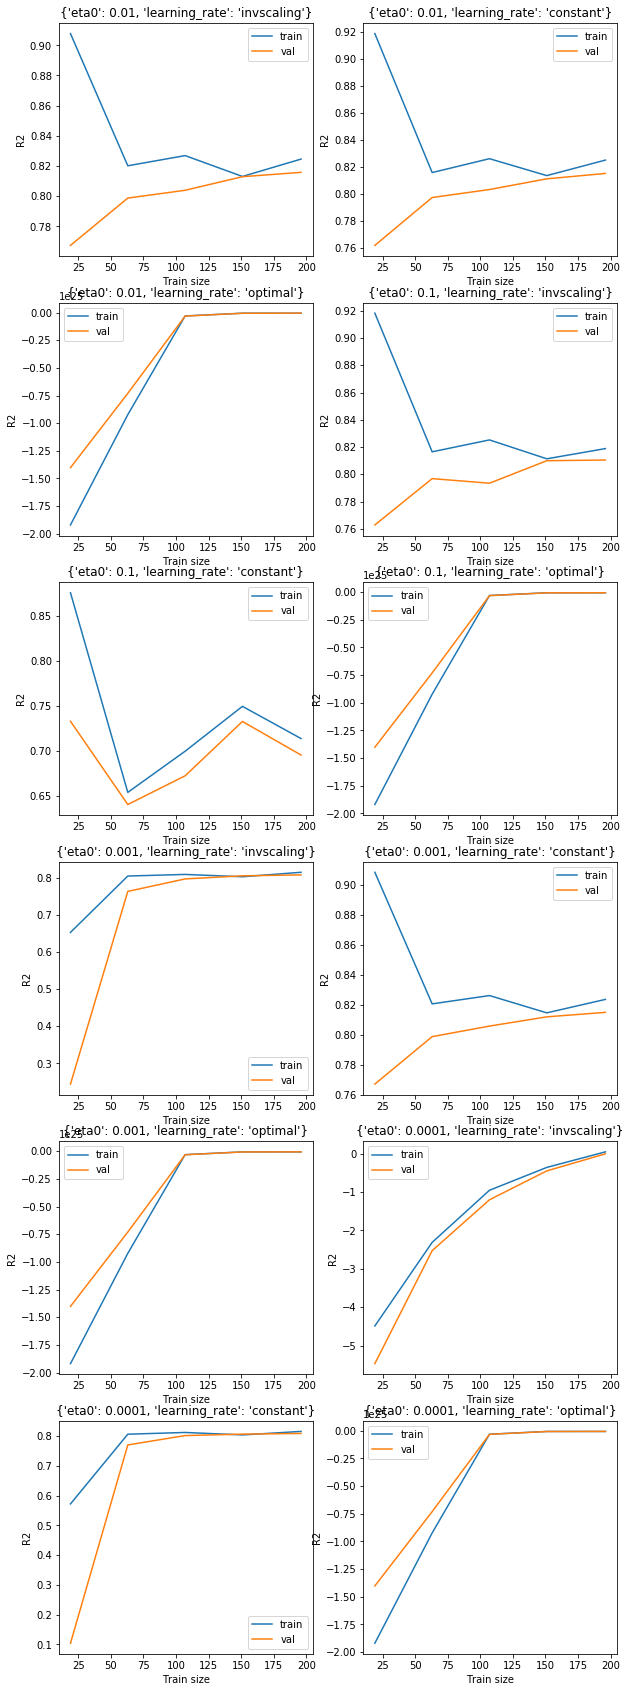

In [22]:
fig, axes = plt.subplots(nrows=6, ncols=2, figsize=(10, 30))
axes = axes.flatten()

for i in range(len(axes)):
    params = results_df.params.values[i]
    model = SGDRegressor(max_iter=1000, tol=1e-3,
                         random_state=8,
                         learning_rate=params['learning_rate'],
                         eta0=params['eta0'])
    train_sizes, train_scores, val_scores = learning_curve(model,
                                                       Z_train, 
                                                       y_train, cv=3)

    ax = axes[i]
    ax.plot(train_sizes, train_scores.mean(axis=1), label='train')
    ax.plot(train_sizes, val_scores.mean(axis=1), label='val')
    ax.legend()
    ax.set(title=str(params), xlabel='Train size', ylabel='R2')    

In [23]:
# Exercise:
# Run GridSearch to find a good parameter combination for
#   Regularization
#
# Start with {'eta0': 0.01, 'learning_rate': 'invscaling'}
# found from previous GridSearch
#
# Hint: the parameters involved are
#    penalty
#    alpha
#    l1_ratio
#
# Use SGDRegressor? to find out more, or go to 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDRegressor.html

In [24]:
params = {
    # type of regularization
    'penalty': [
        'none', 'l2', 'l1', 'elasticnet'        
    ],

    # regularization parameter (lambda)
    'alpha': [
        0.0001, 0.001, 0.01, 10
    ],

    # l1_ratio only applies for 'elasticnet'
    'l1_ratio': [
        0, 0.15, 0.5, 0.85, 1.0
    ]
}

# starter model
model = SGDRegressor(eta0=0.01,
                     learning_rate='invscaling', # best from previous
                     max_iter=1000, tol=1e-3,
                     random_state=8) # sklearn warnings

# gridsearch with above combinations
gs1 = GridSearchCV(model, params, cv=3, return_train_score=True)
gs1.fit(Z_train, y_train)

# Score should be better than 0.8157809300685853
print(gs1.best_score_) # best score
print(gs1.best_params_) # best parameters

0.8158193122863642
{'alpha': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}


In [25]:
results_df1 = pd.DataFrame(gs1.cv_results_)

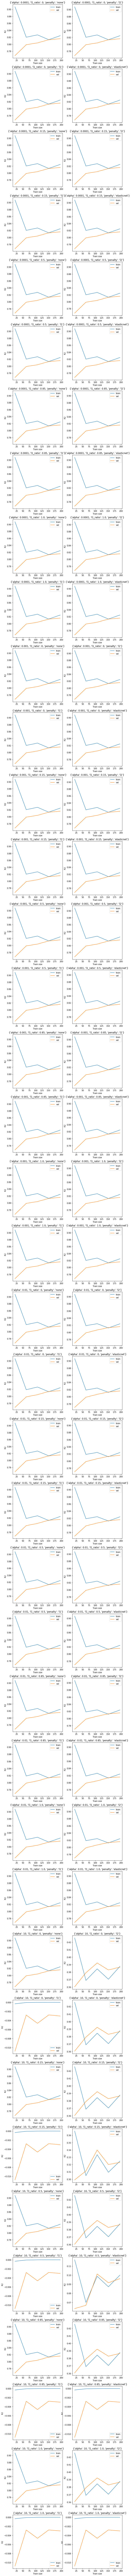

In [26]:
n_params = len(results_df1.params)

fig, axes = plt.subplots(nrows=n_params//2,
                         ncols=2, figsize=(10, 6*n_params//2))
axes = axes.flatten()

for i in range(n_params):
    params = results_df1.params.values[i]
    model = SGDRegressor(eta0=0.01,
                         learning_rate='invscaling',
                         max_iter=1000,
                         tol=1e-3,
                         random_state=8,
                         penalty=params['penalty'],
                         alpha=params['alpha'],
                         l1_ratio=params['l1_ratio'])

    train_sizes, train_scores, val_scores = learning_curve(model,
                                                       Z_train, 
                                                       y_train, cv=3)

    ax = axes[i]
    ax.plot(train_sizes, train_scores.mean(axis=1), label='train')
    ax.plot(train_sizes, val_scores.mean(axis=1), label='val')
    ax.legend()
    ax.set(title=str(params), xlabel='Train size', ylabel='R2')    

In [27]:
gs1.best_params_

{'alpha': 0.01, 'l1_ratio': 0.5, 'penalty': 'elasticnet'}

In [28]:
import numpy as np

# generating a range automatically
print(np.arange(0.004, 0.016, 0.002))
print(np.arange(0.4, 0.6, 0.02))

[0.004 0.006 0.008 0.01  0.012 0.014]
[0.4  0.42 0.44 0.46 0.48 0.5  0.52 0.54 0.56 0.58]


In [29]:
# Search around previous best params
params = {
    # type of regularization
    'penalty': ['elasticnet'],

    # regularization parameter (lambda)
    'alpha': np.arange(0.004, 0.016, 0.002),

    # l1_ratio only applies for 'elasticnet'
    'l1_ratio': np.arange(0.4, 0.6, 0.02)
}

# starter model
model = SGDRegressor(eta0=0.01,
                     learning_rate='invscaling', # best from previous
                     max_iter=1000, tol=1e-3,
                     random_state=8) # sklearn warnings

# gridsearch with above combinations
gs2 = GridSearchCV(model, params, cv=3, return_train_score=True)
gs2.fit(Z_train, y_train)

# Score should be better than 0.8158193122863642
print(gs2.best_score_) # best score
print(gs2.best_params_) # best parameters

0.8158224873764177
{'alpha': 0.008, 'l1_ratio': 0.44000000000000006, 'penalty': 'elasticnet'}


## Plot predictions vs. Truth

This can be a way to determine why our errors are high

In [30]:
# Perform a PCA reduction to 1-d (X)
# Plot X_1d vs. y
# Plot X_1d vs. y_hat (train)
# Plot X_1d vs. y_hat (test)

# Get predictions on entire scaled dataset just
# to plot it with the PCA plot
y_pred_train = gs2.predict(Z_train)
Z_train_pca = pca.transform(Z_train) # need to be 1d for plotting

y_pred_test = gs2.predict(Z_test)
Z_test_pca = pca.transform(Z_test) # need to be 1d for plotting

[Text(0, 0.5, 'mpg'),
 Text(0.5, 0, '1-d PCA projection of data'),
 Text(0.5, 1.0, 'PCA of data vs. mpg')]

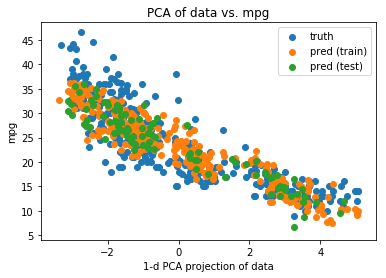

In [31]:
# plot Z vs. y and y_hat to see what the
# model predicts compared to the truth

fig, ax = plt.subplots()
ax.scatter(Z, y, label='truth')
ax.scatter(Z_train_pca, y_pred_train, label='pred (train)') # plot vs the PCA 1d X
ax.scatter(Z_test_pca, y_pred_test, label='pred (test)') # plot vs the PCA 1d X
ax.legend()

ax.set(title='PCA of data vs. mpg',
      xlabel='1-d PCA projection of data',
      ylabel='mpg')

### Try k-best features

Technically, if the model is underfitting, it's not recommended
to drop features.

This is just a demonstration of using K best features to see
if model improves.

In [32]:
# Original features
X.columns

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'acceleration',
       'model year', 'origin'],
      dtype='object')

In [33]:
# coefficients for the features
# look for magnitude
gs2.best_estimator_.coef_

array([-0.76709899,  0.57588701, -0.92845948, -3.8801781 , -0.40498402,
        2.8427622 ,  1.2543734 ])

In [34]:
# if kbest excludes the features with high coefficients (weights)
# recommend re-running GridSearch
X.columns[kbest.get_support()]

Index(['cylinders', 'displacement', 'horsepower', 'weight', 'model year'], dtype='object')

In [35]:
# Even though y wasn't affected by SelectKBest, we
# need to shuffle + split the datasets together because
# otherwise the shuffled rows will not match
X_kb_train, X_kb_test, y_kb_train, y_kb_test = train_test_split(X_kbest,
                                                                y)
X_kb_scaler = StandardScaler()
Z_kb_train = X_kb_scaler.fit_transform(X_kb_train)

model = SGDRegressor(eta0=0.01,
                     learning_rate='invscaling',
                     max_iter=1000,
                     tol=1e-3,
                     random_state=8,
                     alpha=0.008,
                     l1_ratio=0.44000000000000006,
                     penalty='elasticnet')

scores = cross_validate(model, Z_kb_train, y_kb_train, cv=5,
                        return_train_score=True,
                        return_estimator=True) # models

scores

{'fit_time': array([0.0050137 , 0.00300384, 0.00501513, 0.00401044, 0.0050137 ]),
 'score_time': array([0.        , 0.00100183, 0.        , 0.        , 0.00100374]),
 'estimator': (SGDRegressor(alpha=0.008, average=False, early_stopping=False, epsilon=0.1,
         eta0=0.01, fit_intercept=True, l1_ratio=0.44000000000000006,
         learning_rate='invscaling', loss='squared_loss', max_iter=1000,
         n_iter=None, n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
         random_state=8, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=False),
  SGDRegressor(alpha=0.008, average=False, early_stopping=False, epsilon=0.1,
         eta0=0.01, fit_intercept=True, l1_ratio=0.44000000000000006,
         learning_rate='invscaling', loss='squared_loss', max_iter=1000,
         n_iter=None, n_iter_no_change=5, penalty='elasticnet', power_t=0.25,
         random_state=8, shuffle=True, tol=0.001, validation_fraction=0.1,
         verbose=0, warm_start=Fal

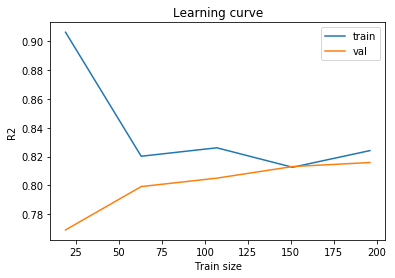

In [36]:
# - learning curve (plot for overfit / underfit)
train_sizes, train_scores, val_scores = plot_learning_curve(model)